# MT Inversion of PNE digitized data

This is a Jupyter Notebook that is adapted from the other examples from this MTtime package. Since the PNE data I (Luis Martinetti) am using is not in the IRIS DMC and the response files are generated by us at MSU, I need to pre-process the waveforms with SAC before doing the inversion process.

- LLNL-CODE-830725
- SPDX-License-Identifier: LGPL-3.0

## "00_Introduction_and_Data_retrieval" Replication

### Questions
**What event id should we use = the one designated by LLNL or the name of the PNE?**


- The data that we are using is hand digitized by Michigan State University, and is not publicly available. Therefore, don't download the data the same way that the other example Jupyter ntoebooks do it. However, we need to follow the same structure.

**THINGS TO DO WITH SAC BEFORE RUNNING THIS CODE:**
- a) Make sure that Bob Herrmann's GF synthetic codes work on your computer(CPS)
- b) Correct data for instrument response (displacement) for PNE data - WWSSN data will be corrected in the code.
- c) Import all info to SAC headers
    - Most importantly: stla, stlo, stel, evla, evlo, evdp, az, baz, dist, O (define origin time), B, KCMPNM
- d) Rotate data to GCP (data has to be same npts for this)
    - Make sure that KCMPNM is set to HLR or HLT (will change based on sampling rate and gain, but R and T should be specified).
- e) For PNE data:
    - The location code changes depending on the instruments used:
        - SK = 00
        - SKD = 10
    - The headers KINST should be set to the instrument type, which will be converted to the location code within the code.
    
    
1) Make a folder with the eventid, this is where eberything is going to take place.
In there we are going to create a few files, station.csv and datetime.csv with the code. 

We are also going to create a folder called "sac" where all of the data will go. Make sure that the data follows the same naming convention as the examples : **NET.STAT.LOC.COMP.dat**  
 


## "01_Data_Processing" Replication

### Questions
**What should the beginning time of the waveforms be - how do I make the PNE waveforms fit the code?**

Here we are going to skip many steps since they don't apply to our data

In [1]:
# Import third-party libraries
import os
from pathlib import Path
import pandas as pd
from obspy import read, read_inventory, UTCDateTime
from obspy.geodetics.base import gps2dist_azimuth
from obspy.core.util.attribdict import AttribDict
import matplotlib.pyplot as plt

### Zero'd horizontals
---
The next cell is to create horizontal components with 0's in the data for stations with only vertical components. The code requires all components even if they are not used.


In [6]:
###DONT RUN#####
#Make the data with one component, have other components with 0's in
stat='TAB'
single = read("./sac/%s.LHZ"%stat)
good = single[0]
good.write("./sac/WWSSN.%s.00.LHZ"%stat, format='SAC')
good.stats
#good.data
#Create Radial component
radial = good.copy()
radial.data = good.data*0
radial.write("./sac/WWSSN.%s.00.LHR"%stat, format='SAC')

trans = good.copy()
trans.data = good.data*0
trans.write("./sac/WWSSN.%s.00.LHT"%stat, format='SAC')

In [21]:
test = read('./sac/WWSSN.KBL.00.LHZ')
test1 = test[0]
test1.stats.sac.knetwk

'WWSSN'

---


In [2]:
#Set some parameters
evid = 'Mangyshlak-3'
event_dir = "."
infile = "datetime.csv"
outfile_name = "station.csv"
df = pd.read_csv(infile,parse_dates=True)

#Read Data
#Move the sac data to the folder specified here, or change the path to match your data structure.
st = read("./sac/*")
st.detrend(type='linear')
st.detrend(type="demean")

#Need to add the info to the Obspy headers
df.to_csv("%s/%s"%(event_dir,"datetime.csv"),index=False) # save origin info to event directory
origin_time =UTCDateTime(df.origin[0])
for tr in st:
    sh = tr.stats.sac
    if sh.kinst == 'SK':
        tr.stats.location = '00'
    if sh.kinst == 'SKD':
        tr.stats.location = '10'
    if sh.kinst == 'HWWSSN':
        tr.stats.location = '00'
    #print(sh.b)
    omarker = origin_time - tr.stats.starttime
    tr.stats.stla = sh.stla
    tr.stats.stlo = sh.stlo
    tr.stats.stel = sh.stel
    tr.stats.evla = sh.evla
    tr.stats.evlo = sh.evlo
    tr.stats.evdp = sh.evdp
    tr.stats.az = sh.az
    tr.stats.baz = sh.baz
    tr.stats.dist = sh.dist #Make sure it is in km
    tr.stats.o = sh.o
    tr.stats.b = sh.b
    tr.stats.channel = sh.kcmpnm
    tr.stats.network = sh.knetwk
    #Obspy trace headers
    
    # Get station names
    netstaloccha = sorted(set([(tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel[:-1]) for tr in st]))
    # Update station names
    netstaloccha = set(
        [(tr.stats.network, tr.stats.station, tr.stats.location, tr.stats.channel[:-1], "ZRT",
          tr.stats.sac.dist, tr.stats.sac.az, tr.stats.sac.stlo, tr.stats.sac.stla) for tr in st.select(component="Z")]
        )
    
    # Save station information to a Pandas table
    header = ("network","station","location","channel","component","distance","azimuth","longitude","latitude")
    df2 = pd.DataFrame(netstaloccha, columns=header)
    df2 = df2.sort_values("distance")
    df2.to_csv("%s/%s"%(event_dir,outfile_name),index=False)

os.system("open -a xcode station.csv")


0

----
## STOP - IMPORTANT:

Modify the **station.csv** file to follow same order that you want, the Digitized data first and then the db or whatever order you wish.

Put the PNE data first in the file and then the database data.


----

In [3]:
!cat 'station.csv'
#If stations not in order, modify the file with a text editor

network,station,location,channel,component,distance,azimuth,longitude,latitude
WWSSN,TAB,00,LH,ZRT,967.553955078,231.251556396,46.3266944885,38.0675010681
WWSSN,SHI,00,LH,ZRT,1592.42272949,188.521514893,52.5133056641,29.6418056488
WWSSN,KBL,00,LH,ZRT,1595.23144531,125.670875549,69.0431671143,34.5408325195
WWSSN,QUE,00,LH,ZRT,1852.25646973,141.012466431,66.9499969482,30.1883068085
WWSSN,NIL,00,LH,ZRT,1947.8092041,119.404907227,73.251701355,33.6500015259


In [4]:
print(st.__str__(extended=True))
#st[12].stats.network

15 Trace(s) in Stream:
WWSSN.KBL.00.LHR | 1970-12-23T07:02:53.999838Z - 1970-12-23T07:17:42.999838Z | 1.0 Hz, 890 samples
WWSSN.KBL.00.LHT | 1970-12-23T07:02:53.999838Z - 1970-12-23T07:17:42.999838Z | 1.0 Hz, 890 samples
WWSSN.KBL.00.LHZ | 1970-12-23T07:02:53.999838Z - 1970-12-23T07:17:42.999838Z | 1.0 Hz, 890 samples
WWSSN.NIL.00.LHR | 1970-12-23T07:04:57.999838Z - 1970-12-23T07:21:19.999838Z | 1.0 Hz, 983 samples
WWSSN.NIL.00.LHT | 1970-12-23T07:04:57.999838Z - 1970-12-23T07:21:19.999838Z | 1.0 Hz, 983 samples
WWSSN.NIL.00.LHZ | 1970-12-23T07:04:57.999838Z - 1970-12-23T07:21:19.999838Z | 1.0 Hz, 983 samples
WWSSN.QUE.00.LHR | 1970-12-23T07:03:55.999838Z - 1970-12-23T07:20:18.999838Z | 1.0 Hz, 984 samples
WWSSN.QUE.00.LHT | 1970-12-23T07:03:55.999838Z - 1970-12-23T07:20:18.999838Z | 1.0 Hz, 984 samples
WWSSN.QUE.00.LHZ | 1970-12-23T07:03:55.999838Z - 1970-12-23T07:20:18.999838Z | 1.0 Hz, 984 samples
WWSSN.SHI.00.LHR | 1970-12-23T07:02:54.999838Z - 1970-12-23T07:17:34.999838Z | 1.0 Hz,

## STOP - Plotting

Figure out what filters work best for the data

SK: bp 15-30 seconds
SKD: bp 20-40 seconds
WWSSN: bp 20-50 seconds


<ipython-input-49-0cf927f0c226>:37: RuntimeWarning: invalid value encountered in true_divide
  tr.data /= max(abs(tr.data))
<ipython-input-49-0cf927f0c226>:37: RuntimeWarning: invalid value encountered in true_divide
  tr.data /= max(abs(tr.data))
<ipython-input-49-0cf927f0c226>:37: RuntimeWarning: invalid value encountered in true_divide
  tr.data /= max(abs(tr.data))
<ipython-input-49-0cf927f0c226>:37: RuntimeWarning: invalid value encountered in true_divide
  tr.data /= max(abs(tr.data))
<ipython-input-49-0cf927f0c226>:37: RuntimeWarning: invalid value encountered in true_divide
  tr.data /= max(abs(tr.data))
<ipython-input-49-0cf927f0c226>:37: RuntimeWarning: invalid value encountered in true_divide
  tr.data /= max(abs(tr.data))
<ipython-input-49-0cf927f0c226>:37: RuntimeWarning: invalid value encountered in true_divide
  tr.data /= max(abs(tr.data))
<ipython-input-49-0cf927f0c226>:37: RuntimeWarning: invalid value encountered in true_divide
  tr.data /= max(abs(tr.data))
<ipython

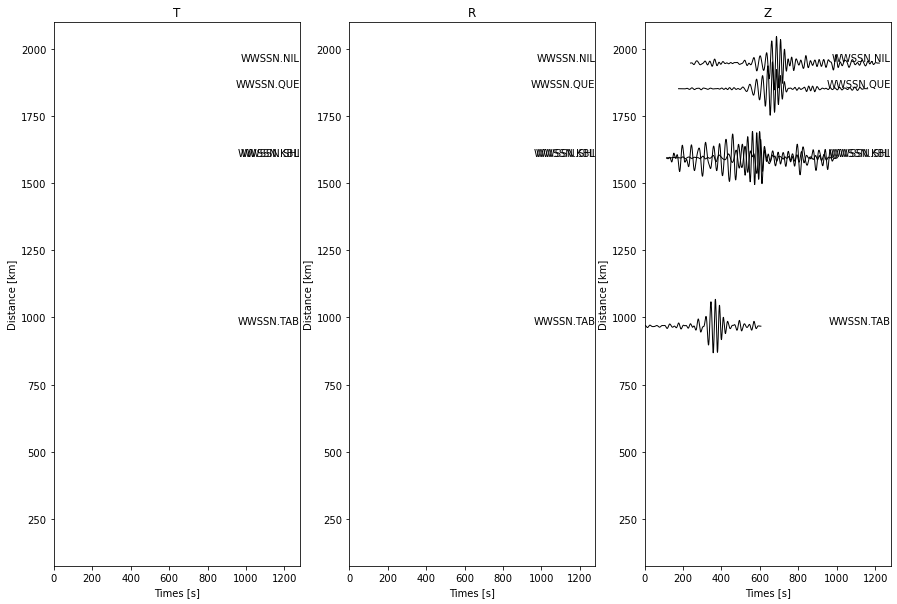

In [49]:
#Plotting Seismograms
#--------------------

#Digitized data-----
dat_plt = st.copy()

#Set PNE and WWSSN filters
SK_filt = [0.033, 0.066] #30-15 s, maybe change to 15 s (0.066)
SKD_filt = [0.025, 0.05] #40-20 s
WWSSN_filt = [0.02,0.05] #30-50 s
corners = 3

#Apply the filters and taper edges to data based on their netowrk and location code (sensor)
for tr in dat_plt:
    if tr.stats.network=='RU' or tr.stats.network=='KR':
        if tr.stats.location=='00':
            tr.filter("bandpass",freqmin=SK_filt[0],freqmax=SK_filt[1],corners=corners,zerophase=True)
            tr.taper(max_percentage=0.05)
        elif tr.stats.location=='10':
            tr.filter("bandpass",freqmin=SKD_filt[0],freqmax=SKD_filt[1],corners=corners,zerophase=True)
            tr.taper(max_percentage=0.05)
    elif tr.stats.network=='WWSSN':
        tr.filter("bandpass",freqmin=WWSSN_filt[0],freqmax=WWSSN_filt[1],corners=corners,zerophase=True)
        tr.taper(max_percentage=0.05) #This could be done in sac too

# Each seismogram is normalized against each trace
xmin = 0
xmax = 1280
ymin = 75
ymax = 2100
#scale = 2 # scale the traces
scale = 100
fig, axes = plt.subplots(1,3,figsize=(15,10))
for component, ax in zip(("T","R","Z"),axes):
    for tr in dat_plt.select(component=component):
        times = tr.times() - (origin_time - tr.stats.starttime)
        tr.data /= max(abs(tr.data))
        tr.data *= scale
        ax.plot(times,tr.data+tr.stats.sac.dist,color="black",linewidth=1)
        ax.text(xmax,tr.stats.sac.dist,"%s.%s"%(tr.stats.network,tr.stats.station),va="bottom",ha="right")
    ax.set_xlim(xmin,xmax)
    ax.set_ylim(ymin,ymax)
    ax.set_xlabel("Times [s]")
    ax.set_ylabel("Distance [km]")
    ax.set_title("%s"%component)
    
print("SK: bp %.0f-%.0f seconds"%(1/SK_filt[1],1/SK_filt[0]))
print("SKD: bp %.0f-%.0f seconds"%(1/SKD_filt[1],1/SKD_filt[0]))
print("WWSSN: bp %.0f-%.0f seconds"%(1/WWSSN_filt[1],1/WWSSN_filt[0]))

## "02_Prepare_Data_and_Synthetics_For_Inversion"

### Here we also specify the Earth model used for the GF calculation, so we can organiza the data better.

In [41]:
# Import third-party libraries
import os
from pathlib import Path
import pandas as pd
from obspy.core import read, UTCDateTime, Stream

In [50]:
station_file = "%s/station.csv"%event_dir

#------------
# EARTH MODEL
#------------
model = "north_mangystau"

sacdir = "./sac" # location of processed data
outdir = "./%s/proc_waves"%(model) # location of filtered/cut/down-sampled data for inversion
os.system("mkdir %s"%model)
os.system("mkdir %s"%outdir)

    
# Check if data directory exist
P = Path(sacdir)
if P.exists():
    # Read event info and station info into Pandas table
    df = pd.read_csv(infile,parse_dates=True)
    station_df = pd.read_csv("%s"%(station_file),parse_dates=True,dtype={"location":str},na_filter=False)
    
    origin_time = UTCDateTime(df["origin"][0])
    st = Stream()
    for _,row in station_df.iterrows():
        st += read("%s/%s.%s.%s.%s[%s]"%(
            sacdir,row.network,row.station,row.location,row.channel,row.component),format="SAC")
        for tr in st:
            sh = tr.stats.sac
            if sh.kinst == 'SK':
                tr.stats.location = '00'
            if sh.kinst == 'SKD':
                tr.stats.location = '10'
            if sh.kinst == 'HWWSSN':
                tr.stats.location = '00'
            #print(sh.b)
            omarker = origin_time - tr.stats.starttime
            tr.stats.stla = sh.stla
            tr.stats.stlo = sh.stlo
            tr.stats.stel = sh.stel
            tr.stats.evla = sh.evla
            tr.stats.evlo = sh.evlo
            tr.stats.evdp = sh.evdp
            tr.stats.az = sh.az
            tr.stats.baz = sh.baz
            tr.stats.dist = sh.dist #Make sure it is in km
            tr.stats.o = sh.o
            tr.stats.b = sh.b
            tr.stats.channel = sh.kcmpnm
            tr.stats.network = sh.knetwk
else:
    print("Directory %s does not exist. %s does not have instrument corrected data."%(sacdir,evid))
    

In [43]:
st

15 Trace(s) in Stream:
WWSSN.TAB.00.LHR | 1970-12-23T06:58:53.999838Z - 1970-12-23T07:11:03.999838Z | 1.0 Hz, 731 samples
WWSSN.TAB.00.LHT | 1970-12-23T06:58:53.999838Z - 1970-12-23T07:11:03.999838Z | 1.0 Hz, 731 samples
WWSSN.TAB.00.LHZ | 1970-12-23T06:58:53.999838Z - 1970-12-23T07:11:03.999838Z | 1.0 Hz, 731 samples
WWSSN.SHI.00.LHR | 1970-12-23T07:02:54.999838Z - 1970-12-23T07:17:34.999838Z | 1.0 Hz, 881 samples
WWSSN.SHI.00.LHT | 1970-12-23T07:02:54.999838Z - 1970-12-23T07:17:34.999838Z | 1.0 Hz, 881 samples
WWSSN.SHI.00.LHZ | 1970-12-23T07:02:54.999838Z - 1970-12-23T07:17:34.999838Z | 1.0 Hz, 881 samples
WWSSN.KBL.00.LHR | 1970-12-23T07:02:53.999838Z - 1970-12-23T07:17:42.999838Z | 1.0 Hz, 890 samples
WWSSN.KBL.00.LHT | 1970-12-23T07:02:53.999838Z - 1970-12-23T07:17:42.999838Z | 1.0 Hz, 890 samples
WWSSN.KBL.00.LHZ | 1970-12-23T07:02:53.999838Z - 1970-12-23T07:17:42.999838Z | 1.0 Hz, 890 samples
WWSSN.QUE.00.LHR | 1970-12-23T07:03:55.999838Z - 1970-12-23T07:20:18.999838Z | 1.0 Hz,

The next cell shows the processing parameters you need to define, you may need to change them for different events. Synthetic Green's functions must have the same filter, reduction velocity and sampling interval as the data.

-----
## STOP - IMPORTANT:

Check the following things:

- What are the frequencies that were recovered after instrument response removal? Make sure that filter falls within this range.

- Check the order of the **stations.csv** file so you filter the files with the correct filters.

- Check what pre-processing has been done on the waveforms so it is not reproduced here.

- **VERY IMPORTANT**:
    - You want the sampling rate at 1 sps, modify the variables accordingly.

----

In [51]:
## Desired sampling interval
dt = 1.0

# Reduction velocity in km/sec, 0 sets the reference time to origin time
vred = 8

# time before and after reference time, data will be cut before and after the reference time
#time_after = 200
time_before = 30 #always keep it at this number
time_after= 800 #Check this number based on the arrival of l

if vred:
    p = 1/vred
else:
    p = 0

#-------------------
# Filter and process
#-------------------
dat_proc = st.copy()

#Set PNE and WWSSN filters
SK_filt = [0.033, 0.066] #30-11 s, maybe change to 15 s (0.066)
SKD_filt = [0.025, 0.05] #40-20 s
WWSSN_filt = [0.02,0.05] #30-50 s
corners = 3


#Apply the filters and taper edges to data based on their netowrk and location code (sensor)
for tr in dat_proc:
    if tr.stats.network=='RU' or tr.stats.network=='KR':
        if tr.stats.location=='00':
            tr.filter("bandpass",freqmin=SK_filt[0],freqmax=SK_filt[1],corners=corners,zerophase=True)
        elif tr.stats.location=='10':
            tr.filter("bandpass",freqmin=SKD_filt[0],freqmax=SKD_filt[1],corners=corners,zerophase=True)
        tr.taper(max_percentage=0.05)
        tr.decimate(factor=int(tr.stats.sampling_rate*dt), strict_length=False, no_filter=True)
        tr.resample(1/dt, strict_length=False, no_filter=True)
        tr.stats.sac.t1 = origin_time + p*(tr.stats.sac.dist) # set reference time
        tr.trim(tr.stats.sac.t1-time_before,tr.stats.sac.t1+time_after,pad=True,fill_value=0)
        tr.data = 100*tr.data # m/s to cm/s
        tr.stats.sac.b = -1*(origin_time - tr.stats.starttime)
        tr.stats.sac.o = 0
        # Save final trace using tdmtpy file name format
        sacout = "%s/%s.%s.dat"%(outdir,tr.id[:-4],tr.id[-1])
        tr.write(sacout,format="SAC")
    #
    elif tr.stats.network=='WWSSN':
        tr.filter("bandpass",freqmin=WWSSN_filt[0],freqmax=WWSSN_filt[1],corners=corners,zerophase=True)
        tr.taper(max_percentage=0.05) #This could be done in sac too
        #tr.decimate(factor=int(tr.stats.sampling_rate*dt), strict_length=False, no_filter=True)
        #tr.resample(1/dt, strict_length=False, no_filter=True)
        tr.stats.sac.t1 = origin_time + p*(tr.stats.sac.dist) # set reference time
        tr.trim(tr.stats.sac.t1-time_before,tr.stats.sac.t1+time_after,pad=True,fill_value=0)
        #tr.data = 100*tr.data # m/s to cm/s
        tr.data = tr.data/10000000 #nm to cm
        tr.stats.sac.b = -1*(origin_time - tr.stats.starttime)
        tr.stats.sac.o = 0
        # Save final trace using tdmtpy file name format
        sacout = "%s/%s.%s.dat"%(outdir,tr.id[:-4],tr.id[-1])
        tr.write(sacout,format="SAC")

### Green's Functions

-------------
Now is time to calculate the synthetic Green's functions
* Execute the FK calculation
* Apply the same filter to the synthetics
* Save them to the appropriate format for inversion

The FK calculation requires two input files, a velocity model file and a distance file. A velocity model file **gil7.d** is provided, this is a 1D model for northern California. We will create the distance file **dfile** from the Pandas table.

In [52]:
#------------
# EARTH MODEL
#------------
#model = "north_mangystau" # This model must match the expected model for CPS. 
#The model has been specified in section 2

#depths = round(df["depth"][0]) # Only compute GFs at catalog depth
#depths = sorted([1,2,5,df["depth"][0]]) # compute GF at 1, 2, 3 km and at catalog depth
depths = sorted([1])
npts = int(1024) # number of points in the time series, must be a power of 2
t0 = int(0) # used to define the first sample point, t0 + distance_in_km/vred

# Location of synthetic Green's functions
green_dir = "%s"%model
#Path(green_dir).mkdir(parents=True,exist_ok=True)

for depth in depths:
    # Create distance file
    dfile = ("{dist:.0f} {dt:.2f} {npts:d} {t0:d} {vred:.1f}\n")
    dfile_out = "%s/dfile"%model
    with open(dfile_out,"w") as f:
        for _,row in station_df.iterrows():
            f.write(dfile.format(dist=row.distance,dt=dt,npts=npts,t0=t0,vred=vred))
    
    # Generate the synthetics
    os.system("hprep96 -M ../vel_models/%s.d -d %s -HS %.4f -HR 0 -EQEX"%(model,dfile_out,depth))
    os.system("hspec96")
    os.system("hpulse96 -D -i > file96")
    os.system("f96tosac -B file96")
    
    # Filter and save the synthetic Green's functions
    greens = ("ZDD","RDD","ZDS","RDS","TDS","ZSS","RSS","TSS","ZEX","REX")
#-----------
## Modify apply right filters at the right places
##-----------
    for index,row in station_df.iterrows():
        for j,grn in enumerate(greens):
            sacin = "B%03d%02d%s.sac"%(index+1,j+1,grn)
            #-----
            #Digitized data
            #-----
            if row.network=='RU' or row.network=='KR': #Might have to figure out a better system in the future
                if row.location=='00':
                    sacout = "%s/%s.%s.%s.%.4f"%(green_dir,row.network,row.station,row.location,depth)
                    tmp = read(sacin,format="SAC")
                    tmp.filter('bandpass',freqmin=SK_filt[0],freqmax=SK_filt[1],corners=corners,zerophase=True)
                    tmp.write("%s.%s"%(sacout,grn),format="SAC") # overwrite
                if row.location=='10':
                    sacout = "%s/%s.%s.%s.%.4f"%(green_dir,row.network,row.station,row.location,depth)
                    tmp = read(sacin,format="SAC")
                    tmp.filter('bandpass',freqmin=SKD_filt[0],freqmax=SKD_filt[1],corners=corners,zerophase=True)
                    tmp.write("%s.%s"%(sacout,grn),format="SAC") # overwrite
            elif row.network=="WWSSN":
                sacout = "%s/%s.%s.%s.%.4f"%(green_dir,row.network,row.station,row.location,depth)
                tmp = read(sacin,format="SAC")
                tmp.filter('bandpass',freqmin=WWSSN_filt[0],freqmax=WWSSN_filt[1],corners=corners,zerophase=True)
                tmp.write("%s.%s"%(sacout,grn),format="SAC") # overwrite

#Uncomment to move unfiltered synthetic SAC files to another folder and save them
#Need to modify to make directory for each depth
#os.system("mkdir %s/%s_synthetic/"%(evid,model))
#os.system("mv B*.sac %s/%s_synthetic/"%(evid,model))
# Uncomment to remove unfiltered synthetic SAC files
os.system("mv file96 hspec96.dat hspec96.grn %s"%green_dir)
os.system("rm B*.sac") # remove the unfiltered SAC files

0

### Create input file for MTtime
Now that we have prepared the data and synthetics for inversion, we can create the input file for tdmtpy.
I will go over the input file format in the next notebook.


In [54]:
# Create headers
headers = dict(datetime=df["origin"][0],
               longitude=df["lon"][0],
               latitude=df["lat"][0],
               depth=",".join([ "%.4f"%d for d in depths]),
               path_to_data='proc_waves',
               path_to_green='.',
               green="herrmann",
               components="ZRT",
               degree=5,
               weight="distance",
               plot=0,
               correlate=0,
              )

#Modified headers form following line: path_to_data=event_dir
# Add station table
pd.options.display.float_format = "{:.2f}".format
frame = {"station": station_df[["network","station","location"]].apply(lambda x: ".".join(x),axis=1)}
df_out = pd.DataFrame(frame)
df_out[["distance","azimuth"]] = station_df[["distance","azimuth"]]
df_out["ts"] = int(30)  #Set equal to the time_before for cutting data
#df_out["ts"] = int(300) #What is this value?
#df_out["npts"] = int(150)
df_out["npts"] = int(800)
df_out["dt"] = dt
df_out["used"] = 1
df_out[["longitude","latitude"]] = station_df[["longitude","latitude"]]
#print(df_out.to_string(index=False))

#Save ro file mtinv.in
# write
with open("mtinv.in","w") as f:
    for key, value in headers.items():
        f.write("{0:<15}{1}\n".format(key,value))
    f.write(df_out.to_string(index=False))
os.system("mv mtinv.in %s"%green_dir)
os.system("open -a xcode %s/mtinv.in"%green_dir)


0

In [55]:
funcs = read('./north_mangystau/*.ZEX')
for st in funcs:
    print(st.data)

[ -3.53601676e-10  -2.87929153e-10  -2.10498619e-10 ...,   1.91141044e-11
   6.14818136e-12   9.71999282e-13]
[ -9.89680213e-11  -4.83589592e-11   1.26407879e-12 ...,   1.63187675e-11
   4.93565258e-12   7.44087897e-13]
[ -1.58798169e-10  -1.04359625e-10  -4.76354546e-11 ...,   1.96574545e-11
   6.09073555e-12   9.33949641e-13]
[ -2.39736120e-10  -1.66658534e-10  -8.87692420e-11 ...,   1.87266383e-11
   6.05052510e-12   9.62430114e-13]
[ -2.57361944e-11   1.05893183e-10   2.41611647e-10 ...,   9.50591670e-14
   3.62558799e-14   6.65135248e-15]
